## Importing Python Libraries

In [1]:
import numpy as np
import pandas as pd
import neattext.functions as nfx
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import gensim
from gensim.models import FastText
import joblib

## Loading and Merging Datasets

In [2]:
df1 = pd.read_csv('../Datasets/goemotions_1.csv')
df2 = pd.read_csv('../Datasets/goemotions_2.csv')
df3 = pd.read_csv('../Datasets/goemotions_3.csv')
df = pd.concat([df1, df2, df3], axis=0)

## Emotion Columns and Overall Labels

In [3]:
positive = [
    "admiration","amusement","approval","caring","curiosity","desire","excitement",
    "gratitude","joy","love","optimism","pride","relief"
]
negative = [
    "anger","annoyance","confusion","disappointment","disapproval","disgust",
    "embarrassment","fear","grief","nervousness","remorse","sadness"
]
neutral = ["realization","surprise","neutral"]

def Emotion_Labels(row):
    if row[positive].sum() > 0:
        return "Positive"
    elif row[negative].sum() > 0:
        return "Negative"
    elif row[neutral].sum() > 0:
        return "Neutral"
    else:
        return pd.NA

df['Emotions'] = df.apply(Emotion_Labels, axis=1)

In [4]:
df.head(5)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,Emotions
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,1,0,0,Negative
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,<NA>
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,1,Neutral
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,0,0,0,0,0,0,0,0,0,Positive
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,1,Neutral


## Dropping Nulls 

In [5]:
df.isnull().sum()

text                       0
id                         0
author                     0
subreddit                  0
link_id                    0
parent_id                  0
created_utc                0
rater_id                   0
example_very_unclear       0
admiration                 0
amusement                  0
anger                      0
annoyance                  0
approval                   0
caring                     0
confusion                  0
curiosity                  0
desire                     0
disappointment             0
disapproval                0
disgust                    0
embarrassment              0
excitement                 0
fear                       0
gratitude                  0
grief                      0
joy                        0
love                       0
nervousness                0
optimism                   0
pride                      0
realization                0
relief                     0
remorse                    0
sadness       

In [6]:
df.dropna(inplace=True)
df.isnull().sum()

text                    0
id                      0
author                  0
subreddit               0
link_id                 0
parent_id               0
created_utc             0
rater_id                0
example_very_unclear    0
admiration              0
amusement               0
anger                   0
annoyance               0
approval                0
caring                  0
confusion               0
curiosity               0
desire                  0
disappointment          0
disapproval             0
disgust                 0
embarrassment           0
excitement              0
fear                    0
gratitude               0
grief                   0
joy                     0
love                    0
nervousness             0
optimism                0
pride                   0
realization             0
relief                  0
remorse                 0
sadness                 0
surprise                0
neutral                 0
Emotions                0
dtype: int64

## Preparing Dataset for Training and Testing

In [7]:
dff = pd.DataFrame()
dff['Text'] = (
    df['text'].astype(str) +
    ' | Author: ' + df['author'].astype(str) +
    ' | Subreddit: ' + df['subreddit'].astype(str)
)
dff['Emotions'] = df['Emotions']
dff.head()

,Text,Emotions
0,That game hurt. | Author: Brdd9 | Subreddit: nrl,Negative
2,"You do right, if you don't care then fuck 'em!...",Neutral
3,Man I love reddit. | Author: MrsRobertshaw | S...,Positive
4,"[NAME] was nowhere near them, he was by the Fa...",Neutral
5,Right? Considering it’s such an important docu...,Positive


In [8]:
del df1,df2,df3,df

## Cleaning the Text

In [9]:
def clean(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\br/\w+', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'[{}\[\]()\|:\"\']', ' ', text)
    text = re.sub(r'[“”‘’]', ' ', text)            
    text = re.sub(r'\|{2,}', ' ', text)              
    text = nfx.remove_emails(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_urls(text)
    text = nfx.remove_userhandles(text)
    text = nfx.remove_phone_numbers(text)
    text = nfx.remove_emojis(text)
    text = nfx.remove_puncts(text)
    text = nfx.remove_multiple_spaces(text)
    text = re.sub(r'[^a-z0-9 ]', ' ', text)           
    text = re.sub(r'\s{2,}', ' ', text)              
    return text.strip()

dff['Text'] = dff['Text'].apply(clean)
dff.head()

,Text,Emotions
0,game hurt author brdd9 subreddit nrl,Negative
2,right care fuck em author labalool subreddit c...,Neutral
3,man love reddit author mrsrobertshaw subreddit...,Positive
4,near them falcon author americanfascist713 sub...,Neutral
5,right considering important document know damn...,Positive


## Splitting the Dataset into Training and Testing Sets

In [10]:
x = dff['Text']
y = dff['Emotions']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

## FastText Embedding Preparation

In [11]:
tokenized_train = [text.split() for text in x_train]
ft_model = FastText(sentences=tokenized_train, vector_size=100, window=5, min_count=2, epochs=10, workers=4)

## Function to get average FastText embedding for each sentence

In [12]:
def get_sentence_vector(model, sentence, size=100):
    words = sentence.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(size)

X_train_ft = np.vstack([get_sentence_vector(ft_model, sent, size=ft_model.vector_size) for sent in x_train])
X_test_ft = np.vstack([get_sentence_vector(ft_model, sent, size=ft_model.vector_size) for sent in x_test])

## Encode Labels

In [13]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Model Construction and Training

#### Logistic Regression

In [14]:
log_clf = LogisticRegression(C=1, penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=300, random_state=42)
log_clf.fit(X_train_ft, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


#### XGBoost

In [15]:
xgb_clf = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_clf.fit(X_train_ft, y_train_enc)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


#### LightGBM

In [16]:
lgbm_clf = LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, class_weight='balanced', random_state=42)
lgbm_clf.fit(X_train_ft, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 166251, number of used features: 100
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,10
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Predicitions

In [17]:
log_pred = log_clf.predict(X_test_ft)
xgb_pred_enc = xgb_clf.predict(X_test_ft)
xgb_pred = le.inverse_transform(xgb_pred_enc)
lgbm_pred = lgbm_clf.predict(X_test_ft)

## Model Evaluation

In [18]:
print("Logistic Regression:")
print(f'Accuracy Score: {accuracy_score(y_test, log_pred)}')
print(f'Precision Score (macro): {precision_score(y_test, log_pred, average="macro")}')
print(f'Recall Score (macro): {recall_score(y_test, log_pred, average="macro")}')
print(f'F1 Score (macro): {f1_score(y_test, log_pred, average="macro")}')

print()

print("XGBoost:")
print(f'Accuracy Score: {accuracy_score(y_test, xgb_pred)}')
print(f'Precision Score (macro): {precision_score(y_test, xgb_pred, average="macro")}')
print(f'Recall Score (macro): {recall_score(y_test, xgb_pred, average="macro")}')
print(f'F1 Score (macro): {f1_score(y_test, xgb_pred, average="macro")}')

print()

print("LightGBM:")
print(f'Accuracy Score: {accuracy_score(y_test, lgbm_pred)}')
print(f'Precision Score (macro): {precision_score(y_test, lgbm_pred, average="macro")}')
print(f'Recall Score (macro): {recall_score(y_test, lgbm_pred, average="macro")}')
print(f'F1 Score (macro): {f1_score(y_test, lgbm_pred, average="macro")}')

Logistic Regression:
Accuracy Score: 0.5263575776532011
Precision Score (macro): 0.5248237722692802
Recall Score (macro): 0.5215217474478931
F1 Score (macro): 0.5175783270198999

XGBoost:
Accuracy Score: 0.62045569376609
Precision Score (macro): 0.6051099521799862
Recall Score (macro): 0.6018064048096844
F1 Score (macro): 0.6032312433033561

LightGBM:
Accuracy Score: 0.5599451435170705
Precision Score (macro): 0.5616899458352141
Recall Score (macro): 0.5594425706612283
F1 Score (macro): 0.5534464470139544


## Confusion Matrix Visualization

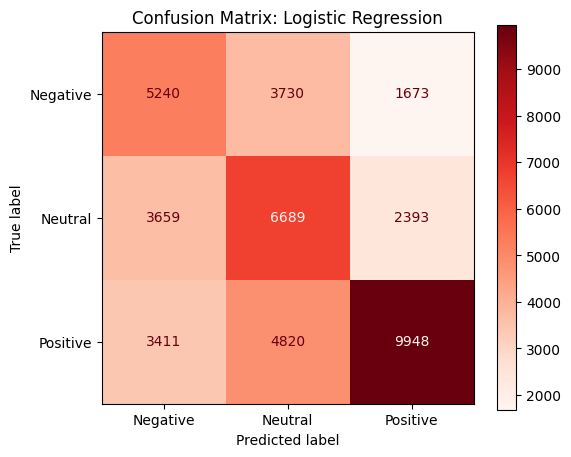

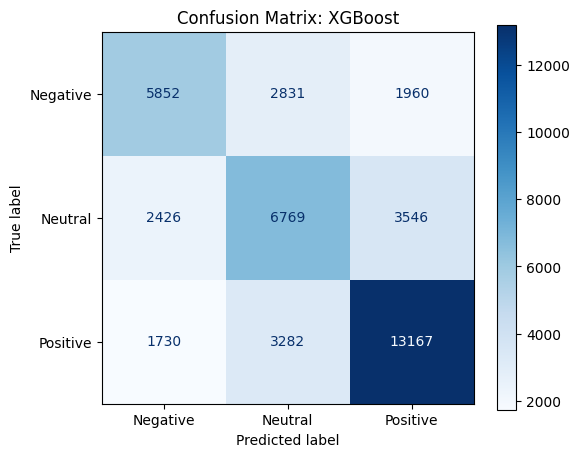

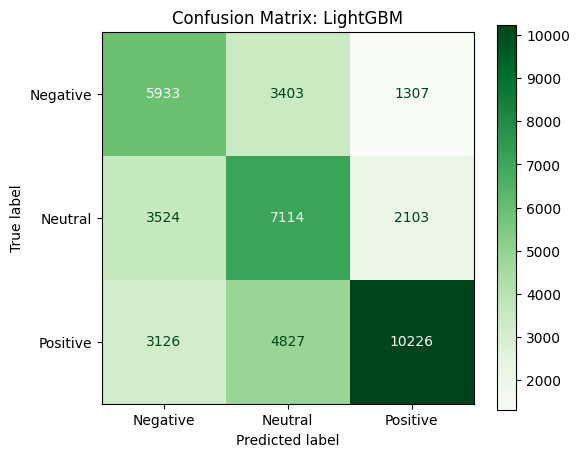

In [19]:
models = {
    'Logistic Regression': log_pred,
    'XGBoost': xgb_pred,
    'LightGBM': lgbm_pred
}
cmaps = {
    'Logistic Regression': 'Reds',
    'XGBoost': 'Blues',
    'LightGBM': 'Greens'
}
labels = le.classes_
for name, preds in models.items():
    cm = confusion_matrix(y_test, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(cmap=cmaps[name], ax=ax, values_format='d')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

## Comparing Metrics

In [20]:
metric_dict = {}
for name, preds in models.items():
    metric_dict[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, average='macro'),
        'Recall': recall_score(y_test, preds, average='macro'),
        'F1': f1_score(y_test, preds, average='macro')
    }

metrics_df = pd.DataFrame(metric_dict).T
metrics_df

,Accuracy,Precision,Recall,F1
Logistic Regression,0.526358,0.524824,0.521522,0.517578
XGBoost,0.620456,0.605110,0.601806,0.603231
LightGBM,0.559945,0.561690,0.559443,0.553446
